In [ ]:
"""
!pip -q install yellowbrick==1.3

!pip -q install kneed
!pip -q install factor_analyzer
!pip -q install seaborn
"""

In [226]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from factor_analyzer import FactorAnalyzer
from yellowbrick.features import PCA as YBPCA
from kneed import KneeLocator
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
#import plotly.express as px

In [525]:
# factor analysis
def evaluate_pcs(num_of_pcs,data):
    def encode_vals(x): #helper functions to suppress loading less than 0.7 
    #a gradual process to lead to this function
    # if x<=-0.5, we drop the variable
        if x <= -0.5 or x >= 0.5: #Adjust the threshold value 
            return x
        else:
            return("")    
    f = FactorAnalyzer(n_factors=num_of_pcs, method = 'principal',rotation='varimax') #Conduct PCA + varimax rotation to extract latent factors 
    f.fit(data)
    loadings = pd.DataFrame(f.loadings_).set_index(data.columns)
    loadings = loadings.applymap(encode_vals)
    loadingcols= list(loadings.columns)
    newcols = {}
    for i in loadingcols:
        newcols[i] = "PC" + str(i+1)
    loadings.rename(columns = newcols,inplace=True)
    
    
    df_pca = f.transform(data)
    return loadings , df_pca

# The following function generates the rotation matrix. Recall that we use
# this matrix to determine if the PCs generated are easily understandable and appropriate.
# The argument "num_of_pcs" specifies, the number of PCs we wish to generate.

In [526]:
def CronbachAlpha(itemscores): #calculate the CronbachAlpha to see how closely related a set of items are as a group
    itemscores = np.asarray(itemscores)
    itemvars = itemscores.var(axis=0, ddof=1)
    tscores = itemscores.sum(axis=1)
    nitems = itemscores.shape[1]
    return (nitems / (nitems-1)) * (1 - (itemvars.sum() / tscores.var(ddof=1)))

In [596]:
bike = pd.read_csv('bike_agg_with_season_no.csv')
bike.head()

,Unnamed: 0,date,rent_count,temperature,rainfall,snowfall,wind_speed,visibility,solar_radiation,dewpoint_temp,humidity,season,holiday,season_no
0,1,2017-12-01,9539,-1.10,0.0,0,1.4,20000,0.0,-17.40,37.5,Winter,No Holiday,4
1,2,2017-12-02,8523,2.70,0.0,0,1.6,14410,0.0,-5.55,55.5,Winter,No Holiday,4
2,3,2017-12-03,7222,4.35,4.0,0,1.6,3380,0.0,2.65,84.5,Winter,No Holiday,4
3,4,2017-12-04,8729,-0.25,0.1,0,3.6,19130,0.0,-12.95,43.5,Winter,No Holiday,4
4,5,2017-12-05,8307,-3.80,0.0,0,0.0,20000,0.0,-17.70,34.5,Winter,No Holiday,4


# 1st Run: 
Dropped snowfall after multiple pca tests with snowfall not in any of components.

In [598]:
# As PCA is a unsupervised learning algorithm, we will drop the Season column
# We will drop datetime and date as well since they are not numeric
bike2 = bike.copy()
bike2.drop(columns = ['date','holiday','rent_count','season_no','season','snowfall'],inplace=True)
bike2.head()

,Unnamed: 0,temperature,rainfall,wind_speed,visibility,solar_radiation,dewpoint_temp,humidity
0,1,-1.10,0.0,1.4,20000,0.0,-17.40,37.5
1,2,2.70,0.0,1.6,14410,0.0,-5.55,55.5
2,3,4.35,4.0,1.6,3380,0.0,2.65,84.5
3,4,-0.25,0.1,3.6,19130,0.0,-12.95,43.5
4,5,-3.80,0.0,0.0,20000,0.0,-17.70,34.5


In [599]:
# remvove first column
bike3 = bike2.iloc[: , 1:]
bike3.head()

,temperature,rainfall,wind_speed,visibility,solar_radiation,dewpoint_temp,humidity
0,-1.10,0.0,1.4,20000,0.0,-17.40,37.5
1,2.70,0.0,1.6,14410,0.0,-5.55,55.5
2,4.35,4.0,1.6,3380,0.0,2.65,84.5
3,-0.25,0.1,3.6,19130,0.0,-12.95,43.5
4,-3.80,0.0,0.0,20000,0.0,-17.70,34.5


In [600]:
list(bike3.columns)

['temperature',
 'rainfall',
 'wind_speed',
 'visibility',
 'solar_radiation',
 'dewpoint_temp',
 'humidity']

In [601]:
bike3.describe()

# we see each attributes have different ranges

,temperature,rainfall,wind_speed,visibility,solar_radiation,dewpoint_temp,humidity
count,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000
mean,12.606232,3.575921,1.640935,14681.076487,0.109589,3.850992,57.957507
std,11.568233,11.789868,0.661204,5578.420791,0.154109,13.194681,16.100348
min,-14.850000,0.000000,0.000000,2185.000000,0.000000,-27.900000,22.000000
25%,2.900000,0.000000,1.150000,9795.000000,0.000000,-5.350000,46.500000
50%,13.500000,0.000000,1.500000,16765.000000,0.015000,4.550000,56.000000
75%,22.400000,0.500000,1.950000,19875.000000,0.190000,15.200000,69.000000
max,33.100000,95.500000,4.000000,20000.000000,0.575000,25.000000,97.000000


In [602]:
_ , p_value = calculate_bartlett_sphericity(bike3)
p_value

0.0

In [603]:
_, kmo_score = calculate_kmo(bike3)
kmo_score 

0.5265909108813215

In [605]:
#A common procedure is to centre each variable by subtracting its mean from every observation, and then rescale those 
#centred values as units of standard deviation. This is commonly called standardizing, normalizing, or Z scoring the data.
colnames = list(bike3.columns)

scaler = StandardScaler(with_mean=True,with_std=True)
scaled_features = pd.DataFrame(scaler.fit_transform(bike3))

scaled_features.columns = colnames

In [606]:
scaled_features.describe()

,temperature,rainfall,wind_speed,visibility,solar_radiation,dewpoint_temp,humidity
count,3.530000e+02,353.000000,3.530000e+02,3.530000e+02,3.530000e+02,3.530000e+02,3.530000e+02
mean,-8.051476e-17,0.000000,-2.012869e-17,-8.051476e-17,-4.025738e-17,4.025738e-17,1.409008e-16
std,1.001419e+00,1.001419,1.001419e+00,1.001419e+00,1.001419e+00,1.001419e+00,1.001419e+00
min,-2.376785e+00,-0.303735,-2.485261e+00,-2.243254e+00,-7.121240e-01,-2.409763e+00,-2.236507e+00
25%,-8.402329e-01,-0.303735,-7.435405e-01,-8.771321e-01,-7.121240e-01,-6.983156e-01,-7.126412e-01
50%,7.737019e-02,-0.303735,-2.134515e-01,3.740990e-01,-6.146522e-01,5.305173e-02,-1.217542e-01
75%,8.478105e-01,-0.261266,4.680915e-01,9.323958e-01,5.225188e-01,8.613409e-01,6.868278e-01
max,1.774070e+00,7.807938,3.572899e+00,9.548354e-01,3.024295e+00,1.605119e+00,2.428389e+00


In [607]:
corr = scaled_features.corr()
corr


,temperature,rainfall,wind_speed,visibility,solar_radiation,dewpoint_temp,humidity
temperature,1.000000,0.147562,-0.252193,0.014470,0.637173,0.956608,0.387105
rainfall,0.147562,1.000000,-0.115957,-0.207893,-0.124522,0.263165,0.519510
wind_speed,-0.252193,-0.115957,1.000000,0.225093,-0.023909,-0.265252,-0.212245
visibility,0.014470,-0.207893,0.225093,1.000000,0.120044,-0.148796,-0.536091
solar_radiation,0.637173,-0.124522,-0.023909,0.120044,1.000000,0.533142,-0.034113
dewpoint_temp,0.956608,0.263165,-0.265252,-0.148796,0.533142,1.000000,0.620568
humidity,0.387105,0.519510,-0.212245,-0.536091,-0.034113,0.620568,1.000000


<AxesSubplot:>

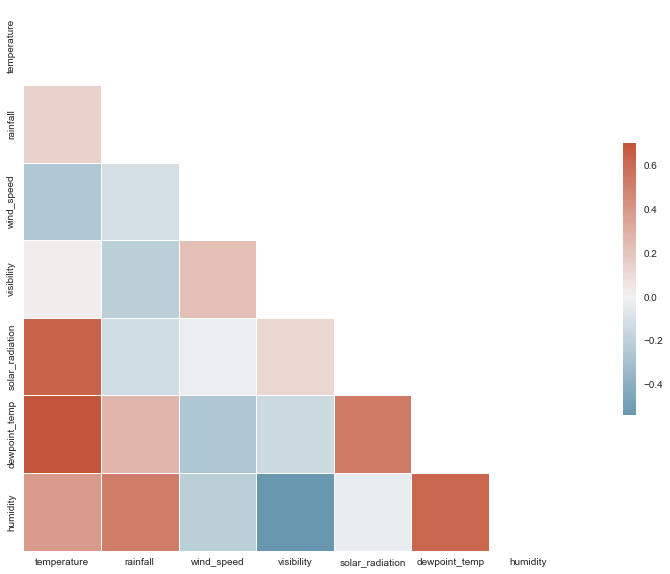

In [608]:
plt.subplots(figsize=(20, 10))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

mask = np.triu(np.ones_like(corr, dtype=bool))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,cmap=cmap,vmax =0.7, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [609]:
#We will set n_components to 10

N = len(scaled_features.columns)
pca = PCA(n_components=N)
pca.fit(scaled_features)

PCA(n_components=7)

In [610]:
#outputs an array of the variance explained by each component scaled to the total of 1.
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio

array([0.41614935, 0.25163531, 0.13257795, 0.10809943, 0.06396277,
       0.0267197 , 0.00085549])

In [611]:
# Cumulative sum of principal components i.e. Cumulative variance of 2 = PC1 variance + PC2 variance
cumulative_variance = np.cumsum(np.round(explained_variance_ratio, decimals=3))
cumulative_variance

array([0.416, 0.668, 0.801, 0.909, 0.973, 1.   , 1.001])

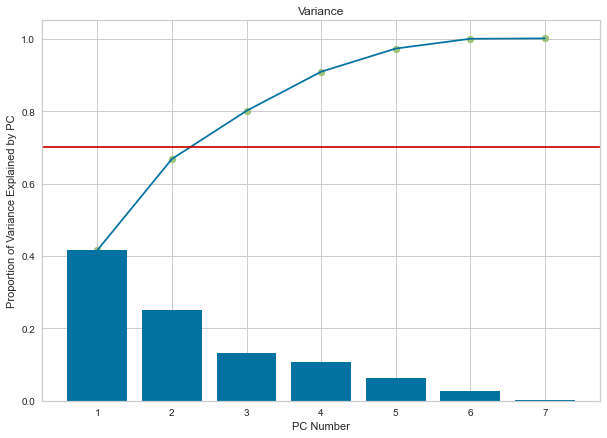

In [612]:
x = list(range(1,N+1))
plt.figure(figsize=(10, 7)) 
plt.bar(x,explained_variance_ratio)
plt.scatter(range(1,N+1),cumulative_variance)
plt.plot(x,cumulative_variance)
plt.title('Variance')
plt.xlabel('PC Number')
plt.ylabel('Proportion of Variance Explained by PC')
plt.axhline(y=0.7, color = 'r')

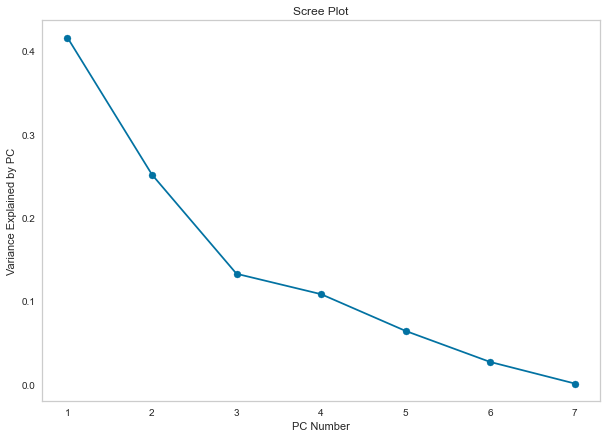

In [613]:
#Scree Plot 
plt.figure(figsize=(10, 7)) 
plt.scatter(range(1,N+1),pca.explained_variance_ratio_)
plt.plot(range(1,N+1),pca.explained_variance_ratio_)
plt.title('Scree Plot')
plt.xlabel('PC Number')
plt.ylabel('Variance Explained by PC')
plt.grid()

In [614]:
kl = KneeLocator(range(1, N+1), pca.explained_variance_ratio_, curve="convex", direction="decreasing")

kl.elbow

3

In [615]:
pca_label, df_pca_array =evaluate_pcs(3,scaled_features[colnames])
pca_label
# from the elbow plot

,PC1,PC2,PC3
temperature,0.947734,,
rainfall,,0.816227,
wind_speed,,,0.893213
visibility,,-0.535377,0.544678
solar_radiation,0.828107,,
dewpoint_temp,0.879032,,
humidity,,0.84833,


In [594]:
print(CronbachAlpha(scaled_features[['temperature','solar_radiation','dewpoint_temp']])) #Reliability of PC1
print(CronbachAlpha(scaled_features[['rainfall','humidity']])) #Reliability of PC2
print(CronbachAlpha(scaled_features[['wind_speed','visibility']])) #Reliability of PC2

0.8796394197418674
0.6837862014257663
0.3674708109017266


In [616]:
df_pca = pd.DataFrame(df_pca_array, columns =['PC1','PC2','PC3'])
df_pca.head()

,PC1,PC2,PC3
0,-1.124018,-1.057408,-0.058007
1,-0.832697,-0.179328,-0.217301
2,-0.858504,1.265381,-0.936323
3,-1.011619,-0.027477,2.669876
4,-1.218035,-1.643449,-1.833559


# Drop visiblility


In [617]:
df_wo_vis = scaled_features.drop(columns = ['visibility'])
N = len(df_wo_vis.columns)
model3 = PCA(n_components = N)
model3.fit(df_wo_vis)
explained_variance3 = model3.explained_variance_ratio_ #Explained Variance Ratio

explained_variance3

array([0.47398   , 0.2466971 , 0.15095782, 0.08436399, 0.04300129,
       0.00099981])

In [618]:
cumulative_variance3 = np.cumsum(np.round(explained_variance3, decimals=3))

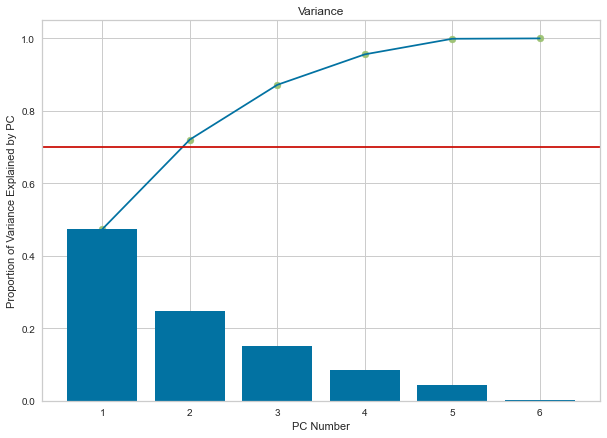

In [619]:
x = list(range(1,N+1))
plt.figure(figsize=(10, 7)) 
plt.bar(x,explained_variance3)
plt.scatter(range(1,N+1),cumulative_variance3)
plt.plot(x,cumulative_variance3)
plt.title('Variance')
plt.xlabel('PC Number')
plt.ylabel('Proportion of Variance Explained by PC')
plt.axhline(y=0.7, color='r')

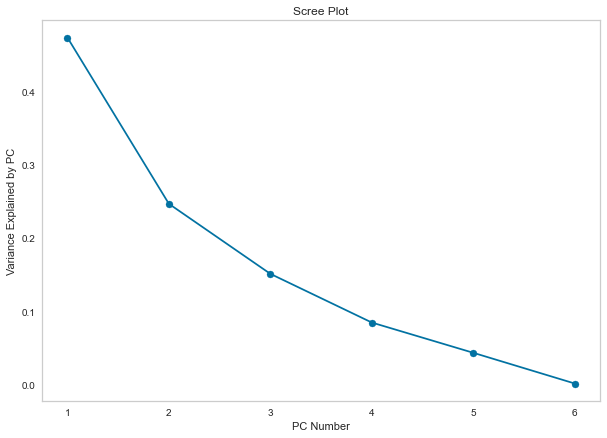

In [620]:
#Scree Plot 
plt.figure(figsize=(10, 7)) 
plt.scatter(range(1,N+1),explained_variance3)
plt.plot(range(1,N+1),explained_variance3)
plt.title('Scree Plot')
plt.xlabel('PC Number')
plt.ylabel('Variance Explained by PC')
plt.grid()

In [621]:
kl2 = KneeLocator(range(1, N+1), model3.explained_variance_ratio_, curve="convex", direction="decreasing")
kl2.elbow

3

In [624]:
pca_label2, df_pca_array2 = evaluate_pcs(2,df_wo_vis)
pca_label2

,PC1,PC2
temperature,0.913231,
rainfall,,0.812337
wind_speed,,
solar_radiation,0.868147,
dewpoint_temp,0.833172,0.510212
humidity,,0.862303


In [626]:
# 2 PCs
print(CronbachAlpha(scaled_features2[['temperature','solar_radiation','dewpoint_temp']])) #Reliability of PC1
print(CronbachAlpha(scaled_features2[['rainfall','dewpoint_temp','humidity']])) #Reliability of PC2

0.8375002484595583
0.7308365838460058


In [627]:
df_pca2 = pd.DataFrame(df_pca_array2, columns =['PC1','PC2'])
df_pca2.head()

,PC1,PC2
0,-1.134125,-0.766546
1,-0.791859,-0.159990
2,-0.691014,0.926026
3,-1.105151,-1.160946
4,-1.166911,-0.466100



# 3th Run: Restart and drop dewpoint_temp

In [628]:
bike5 = bike.copy()
bike5.drop(columns = ['date','holiday','rent_count','season_no','season','dewpoint_temp','snowfall'
                          ],inplace=True)
bike5.head()

,Unnamed: 0,temperature,rainfall,wind_speed,visibility,solar_radiation,humidity
0,1,-1.10,0.0,1.4,20000,0.0,37.5
1,2,2.70,0.0,1.6,14410,0.0,55.5
2,3,4.35,4.0,1.6,3380,0.0,84.5
3,4,-0.25,0.1,3.6,19130,0.0,43.5
4,5,-3.80,0.0,0.0,20000,0.0,34.5


In [629]:
bike_wo_dp = bike5.iloc[: , 1:]
bike_wo_dp.head()

,temperature,rainfall,wind_speed,visibility,solar_radiation,humidity
0,-1.10,0.0,1.4,20000,0.0,37.5
1,2.70,0.0,1.6,14410,0.0,55.5
2,4.35,4.0,1.6,3380,0.0,84.5
3,-0.25,0.1,3.6,19130,0.0,43.5
4,-3.80,0.0,0.0,20000,0.0,34.5


In [635]:
list(bike_wo_dp.columns)

['temperature',
 'rainfall',
 'wind_speed',
 'visibility',
 'solar_radiation',
 'humidity']

In [636]:
_ , p_value = calculate_bartlett_sphericity(bike_wo_dp)
p_value

4.992678540636784e-125

In [637]:
_, kmo_score = calculate_kmo(bike_wo_dp)
kmo_score 

0.44460517206152017

In [638]:
colnames = list(bike_wo_dp.columns)

scaled_features3 = pd.DataFrame(scaler.fit_transform(bike_wo_dp))

scaled_features3.columns = colnames

<AxesSubplot:>

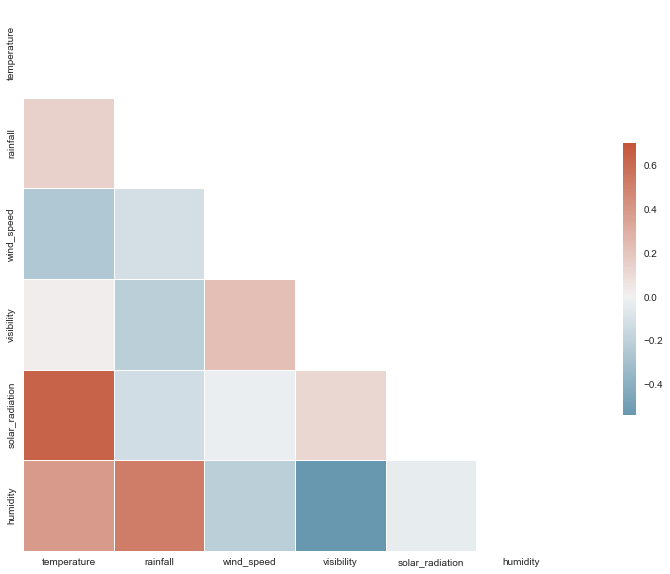

In [639]:
corr = scaled_features3.corr()
plt.subplots(figsize=(20, 10))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

mask = np.triu(np.ones_like(corr, dtype=bool))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,cmap=cmap,vmax =0.7, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [640]:
N = len(scaled_features3.columns)
model5 = PCA(n_components = N)
model5.fit(scaled_features3)
explained_variance5 = model5.explained_variance_ratio_ #Explained Variance Ratio
cumulative_variance5 = np.cumsum(np.round(explained_variance5, decimals=3))

kl4 = KneeLocator(range(1, N+1), model5.explained_variance_ratio_, curve="convex", direction="decreasing")
kl4.elbow

3

In [645]:
pca_label4, df_pca_array4 = evaluate_pcs(3,scaled_features3)
pca_label4

,PC1,PC2,PC3
temperature,,0.896794,
rainfall,0.836503,,
wind_speed,,,0.894806
visibility,-0.519915,,0.543574
solar_radiation,,0.894242,
humidity,0.853781,,


In [646]:
print(CronbachAlpha(scaled_features3[['rainfall','humidity']])) #Reliability of PC1
print(CronbachAlpha(scaled_features3[['temperature','solar_radiation']])) #Reliability of PC2
print(CronbachAlpha(scaled_features3[['wind_speed','visibility']]))

0.6837862014257663
0.7783817153862087
0.3674708109017266


In [647]:
df2_wo_vis = scaled_features.drop(columns = ['visibility','dewpoint_temp'])
N = len(df2_wo_vis.columns)
model6 = PCA(n_components = N)
model6.fit(df2_wo_vis)
explained_variance6 = model6.explained_variance_ratio_ #Explained Variance Ratio
cumulative_variance6 = np.cumsum(np.round(explained_variance6, decimals=3))
pca_label6, df_pca_array6 = evaluate_pcs(2,df2_wo_vis)
pca_label6


,PC1,PC2
temperature,,0.864284
rainfall,0.817603,
wind_speed,,
solar_radiation,,0.913608
humidity,0.859588,


In [648]:
print(CronbachAlpha(scaled_features[['rainfall','humidity']])) #Reliability of PC2
print(CronbachAlpha(scaled_features[['temperature','solar_radiation']])) #Reliability of PC1

0.6837862014257663
0.7783817153862087
